Wagner-Whitin Algorithm For Production Planning

In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [39]:
# forecasts
data = pd.read_csv('demand_forecasts.csv', sep=";")
data

,period,forecast
0,1,200
1,2,150
2,3,100
3,4,50
4,5,50
5,6,100
6,7,150
7,8,200
8,9,200
9,10,250


In [40]:
#costs
cost_data = pd.read_csv('costs.csv', sep=";")
cost_data

,type,cost
0,setup,500
1,holding,1
2,production,50


In [41]:
# Setup Cost Per Production Run
setup_cost = cost_data.loc[0, 'cost']

# Holding Cost Per Unit
holding_cost = cost_data.loc[1, 'cost']

# Production Cost Per Unit
production_cost = cost_data.loc[2, 'cost']

In [42]:
# Create columns
data_calc = data.copy()

for i in data_calc['period'].unique():
    data_calc['Order {}'.format(i)] = 0

# Order 1
order = 1
for index, row in data_calc.iterrows():
    current_month = data_calc.loc[index,'period']
    cost = 0
    # 1 set up
    cost += setup_cost
    if current_month > 1:
        for t in range(1, current_month+1):
            cost += (t-1) * data_calc.loc[t-1,'forecast'] * holding_cost
    data_calc.loc[index,'Order {}'.format(order)] = cost

# Order 2
for order in range(2, 13):
    for index, row in data_calc.iterrows():
        current_month = data_calc.loc[index,'period']
        if current_month >= order:
            cost = 0

            # Best option best Period 1
            values = list(data_calc.loc[order-2,['Order {}'.format(i) for i in range(1, order+1)]].values)
            best = min([i for i in values if i >0])

            # Add
            cost += best + setup_cost
            for t in range(order, current_month+1):
                cost += (t-order) * data_calc.loc[t-1,'forecast'] * holding_cost
            data_calc.loc[index,'Order {}'.format(order)] = cost

data_calc = data_calc.set_index('period').drop(['forecast'], axis = 1).T
data_calc

period,1,2,3,4,5,6,7,8,9,10,11,12
Order 1,500,650,850,1000,1200,1700,2600,4000,5600,7850,10850,13600
Order 2,0,1000,1100,1200,1350,1750,2500,3700,5100,7100,9800,12300
Order 3,0,0,1150,1200,1300,1600,2200,3200,4400,6150,8550,10800
Order 4,0,0,0,1350,1400,1600,2050,2850,3850,5350,7450,9450
Order 5,0,0,0,0,1500,1600,1900,2500,3300,4550,6350,8100
Order 6,0,0,0,0,0,1700,1850,2250,2850,3850,5350,6850
Order 7,0,0,0,0,0,0,2100,2300,2700,3450,4650,5900
Order 8,0,0,0,0,0,0,0,2350,2550,3050,3950,4950
Order 9,0,0,0,0,0,0,0,0,2750,3000,3600,4350
Order 10,0,0,0,0,0,0,0,0,0,3050,3350,3850


In [43]:
costs, initials, nexts, quantities = [], [], [], []
i = 12
while i>1:
    # Order with the minimum cost
    initial_step = i
    next_step = data_calc[data_calc[i]>0][i].idxmin()
    cost = data_calc[data_calc[i]>0][i].min()
    # Next Step
    next_id = int(next_step.replace('Order ',''))
    i = next_id - 1
    # Quantity
    quantity = data[data['period'].isin(range(next_id, initial_step+1))]['forecast'].sum()

    costs.append(cost)
    initials.append(initial_step)
    nexts.append(next_id)
    quantities.append(quantity)

df_results = pd.DataFrame({'backward':range(1, len(initials)+1),
                           'initial':initials,
                           'nexts':nexts,
                           'cost':costs,
                           'quantity':quantities}).set_index('backward')
df_results

,initial,nexts,cost,quantity
backward,,,,
1,12,11,3750,550
2,10,9,3000,450
3,8,6,2250,450
4,5,1,1200,550


In [44]:
# Final Results
results_final = data.copy()

# Production
month_prod = df_results['nexts'].values
prod_dict = dict(zip(month_prod, df_results.quantity.values))

# Values
results_final['production'] = results_final['period'].apply(lambda t: prod_dict[t] if t in month_prod else 0)

# Inventory On Hand
results_final['IOH'] = (results_final['production'] - results_final['forecast']).cumsum()

# Holding Cost
results_final['Holding Cost'] = (results_final['IOH'] * holding_cost)

# Set Up Cost
results_final['Set-Up Costs'] = results_final['production'].apply(lambda t: setup_cost if t > 0 else 0)

# Production Cost
results_final['Production Cost'] = (results_final['production'] * production_cost)

# Total Cost
results_final['Total Cost'] = results_final[['Holding Cost', 'Set-Up Costs', 'Production Cost']].sum(axis = 1)

Total = results_final['Total Cost'].sum()
print("Total Cost: {:,}$".format(Total))
results_final

Total Cost: 103,750$


,period,forecast,production,IOH,Holding Cost,Set-Up Costs,Production Cost,Total Cost
0,1,200,550,350,350,500,27500,28350
1,2,150,0,200,200,0,0,200
2,3,100,0,100,100,0,0,100
3,4,50,0,50,50,0,0,50
4,5,50,0,0,0,0,0,0
5,6,100,450,350,350,500,22500,23350
6,7,150,0,200,200,0,0,200
7,8,200,0,0,0,0,0,0
8,9,200,450,250,250,500,22500,23250
9,10,250,0,0,0,0,0,0


Text(0, 0.5, 'Units')

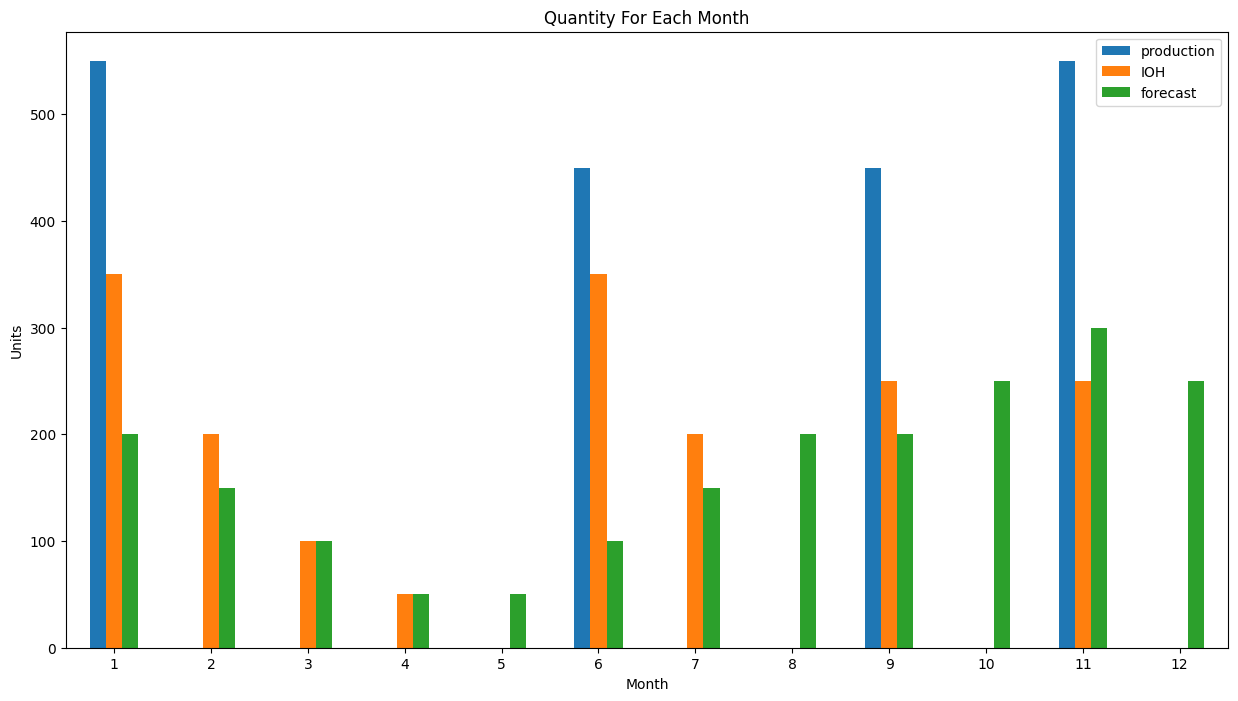

In [45]:
results_final.plot.bar(x = 'period', y = ['production', 'IOH', 'forecast'], rot = 360, figsize=(15, 8))
plt.title("Quantity For Each Month")
plt.xlabel("Month")
plt.ylabel("Units")